In [1]:
import os
import time
import math
import re
import struct
import traceback
import codecs
import bitstring

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import cv2

from PIL import Image
import IPython.display as display

In [2]:
os.listdir('.')

['.ipynb_checkpoints',
 'co59-utf8.txt',
 'ETL4C',
 'ETL4INFO',
 'etl_4_inspect_data.ipynb',
 'README.md']

In [3]:
t56s = '0123456789[#@:>? ABCDEFGHI&.](<  JKLMNOPQR-$*);\'|/STUVWXYZ ,%="!'

def T56(c):
    return t56s[c]

with codecs.open('co59-utf8.txt', 'r', 'utf-8') as co59f:
    co59t = co59f.read()
    
co59l = co59t.split()
CO59 = {}
for c in co59l:
    ch = c.split(':')
    co = ch[1].split(',')
    CO59[(int(co[0]), int(co[1]))] = ch[0]

In [4]:
file_list = [
    'ETL4C',
]

In [5]:
filename = file_list[0]
file_stream = bitstring.ConstBitStream(filename=filename)

In [6]:
RECORD_LENGTH = 2952
skip = 0
file_stream.pos = skip * RECORD_LENGTH

In [7]:
record = file_stream.readlist(','.join([
    '2*uint:36',
    'uint:8',
    'pad:28',
    'uint:8',
    'pad:28',
    '4*uint:6', # 4 Character Code - [4:8]
    'pad:12',
    '15*uint:36',
    'pad:1008',
    'bytes:21888', # 16 Gray Level (4bit/pixel) Image Data 72(X-axis size) * 76(Y-axis size) = 5472 pixels - [23]
]))

In [8]:
print(type(record), len(record))
for idx, v in enumerate(record[:-1]):
    print(f'{idx} - {v}')

<class 'list'> 24
0 - 500100
1 - 5001
2 - 177
3 - 129
4 - 24
5 - 16
6 - 16
7 - 17
8 - 0
9 - 0
10 - 1
11 - 0
12 - 1
13 - 23
14 - 9144
15 - 11
16 - 741202
17 - 741216
18 - 72
19 - 76
20 - 16
21 - 133
22 - 0


In [9]:
record_dict = {
    'character': ''.join(map(T56, record[4:8])), # 4 Character Code - [4:8]
    'image_data': record[23], # 16 Gray Level (4bit/pixel) Image Data 72(X-axis size) * 76(Y-axis size) = 5472 pixels - [23]
}

In [10]:
record_dict['character']

'H  A'

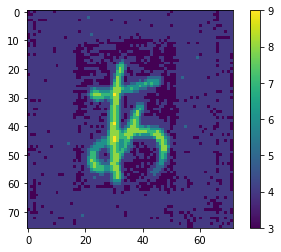

In [11]:
width = 72
height = 76
np_img = np.array(Image.frombytes('F', (width, height), record_dict['image_data'], 'bit', 4))

plt.imshow(np_img)
plt.colorbar()

In [12]:
def show_image(filename, pos=0):
    f = bitstring.ConstBitStream(filename=filename)
    f.bytepos = pos * 2952
    r = f.readlist('2*uint:36,uint:8,pad:28,uint:8,pad:28,4*uint:6,pad:12,15*uint:36,pad:1008,bytes:2736')
    print(''.join([t56s[c] for c in r[4:8]]))
    np_img = np.array(Image.frombytes('F', (r[18], r[19]), r[-1], 'bit', 4))
    plt.imshow(np_img)
    plt.colorbar()

In [13]:
idx = 500

H RI


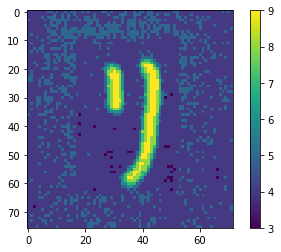

In [14]:
show_image(filename, pos=idx)
idx += 1

In [15]:
total_samples = 0
record_count = {}

for filename in file_list:
    file_stream = bitstring.ConstBitStream(filename=filename)
    while True:
        try:
            r = file_stream.readlist('2*uint:36,uint:8,pad:28,uint:8,pad:28,4*uint:6,pad:12,15*uint:36,pad:1008,bytes:2736')
        except:
            break
            
        total_samples += 1
        
        record_dict = {
            'character': ''.join([t56s[c] for c in r[4:8]]), # 4 Character Code - [4:8]
            'image_data': r[23], # 16 Gray Level (4bit/pixel) Image Data 72(X-axis size) * 76(Y-axis size) = 5472 pixels - [23]
        }

        name = record_dict['character']

        if name in record_count.keys():
            record_count[name] += 1
        else:
            record_count[name] = 1

In [16]:
total_samples

6120

In [17]:
len(record_count.keys())

51

In [18]:
record_count

{'H  A': 120,
 'H  I': 120,
 'H  U': 120,
 'H  E': 120,
 'H  O': 120,
 'H KA': 120,
 'H KI': 120,
 'H KU': 120,
 'H KE': 120,
 'H KO': 120,
 'H SA': 120,
 'H SI': 120,
 'H SU': 120,
 'H SE': 120,
 'H SO': 120,
 'H TA': 120,
 'H TI': 120,
 'H TU': 120,
 'H TE': 120,
 'H TO': 120,
 'H NA': 120,
 'H NI': 120,
 'H NU': 120,
 'H NE': 120,
 'H NO': 120,
 'H HA': 120,
 'H HI': 120,
 'H HU': 120,
 'H HE': 120,
 'H HO': 120,
 'H MA': 120,
 'H MI': 120,
 'H MU': 120,
 'H ME': 120,
 'H MO': 120,
 'H YA': 120,
 'H YI': 120,
 'H YU': 120,
 'H YE': 120,
 'H YO': 120,
 'H RA': 120,
 'H RI': 120,
 'H RU': 120,
 'H RE': 120,
 'H RO': 120,
 'H WA': 120,
 'H WI': 120,
 'H WU': 120,
 'H WE': 120,
 'H WO': 120,
 'H  N': 120}

In [19]:
csv_filename = 'classes.tsv'
with open(csv_filename, mode='w', encoding='utf-8') as f:
    f.write('class\tnum_samples\n')
    for k in record_count.keys():
        log_str = f'{k}\t{record_count[k]}\n'
        f.write(log_str)
pd_df = pd.read_csv(csv_filename, encoding='utf-8', sep='\t')
pd_df = pd_df.sort_values(['class'])
pd_df.to_csv(csv_filename, encoding='utf-8', index=False, sep='\t')